In [1]:
# Examine base case results
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import gsw
import cmocean
import utide
from pandas import date_range

In [2]:
def along_fjord_state(file):

    file0 = xr.open_dataset(file)
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = file.isel(X=range(200), Xp1=range(201), Y=range(35,45), Yp1=range(35,45)) # confine to the fjord domain
    
    time = state.T.data
    X = state.X.data 
    x_dist = X / 1000
    depth = state.Z.data
    pres = gsw.p_from_z(depth, -48.25)
    pt = state.Temp.data.mean(2) # Y-axis average
    s = state.S.data.mean(2)
    #p = np.tile(pres,[len(X),1]).T
    p = np.broadcast_to(pres[np.newaxis, :, np.newaxis], pt.shape)
    rho = gsw.rho(s, pt, p)
    
    # Along-fjord velocity
    u0 = state.U.data # dims = T, Z, Y, Xp1
    u = (u0[:, :, :, 1:].mean(2) + u0[:, :, :, :-1].mean(2)) / 2
    
    # Vetical velocity
    W0 = state.W.data
    bt = np.zeros((W0.shape[0],1,W0.shape[2],W0.shape[3])) # Add vertical velocity (0 m/s) at the bottom
    W = np.concatenate((W0, bt), axis=1)
    wzy = (W[:,1:,:,:] + W[:,:-1,:,:]) / 2
    w = wzy.mean(2)
    
#     # Initial temp and mask
#     pt0 = state.Temp.data.mean(2)[0,:,:]
#     mask = (pt0 == 0)
#     pt[mask] = np.nan
#     s[mask] = np.nan
#     rho[mask] = np.nan
#     u[mask] = np.nan
#     w[mask] = np.nan
    
        
    return (x_dist, depth, time, pt, s, rho, u, w)

In [3]:
def cross_fjord_state(file, xid):

    file0 = xr.open_dataset(file)
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = file.isel(X=range(200), Xp1=range(201), Y=range(35,45), Yp1=range(35,46)) # confine to the fjord domain
    
    time = state.T.data
    y_dist = state.Y.data - 25500 
    depth = state.Z.data
    pres = gsw.p_from_z(depth, -48.25)
    pt = state.Temp.data[:,:,:,xid]
    s = state.S.data[:,:,:,xid]
    p = np.broadcast_to(pres[np.newaxis, :, np.newaxis], pt.shape)
    rho = gsw.rho(s, pt, p)
    
    # Along-fjord velocity
    u0 = (state.U.data[:, :, :, :] + state.U.data[:, :, :, :]) / 2
    u = u0[:,:,:,xid]
    
    # Cross-fjord velocity
    v0 = state.V.data # dims = T,Z,Yp1,X
    v = (v0[:, :, 1:, xid] + v0[:, :, :-1, xid]) / 2
           
    return (y_dist, depth, time, pt, s, rho, u, v)

In [4]:
input_file = '/work/oceans/wbao/MITgcm_results/jorgemontt/1_Tide_test/state_005.nc'

U0 = 5e-3 # Tidal amplitude at ob

X, Z1, T1, temp1, sal1, den1, u1, w1 = along_fjord_state(input_file)
xid = 20
Y, Z2, T2, temp2, sal2, den2, u2, v2 = cross_fjord_state(input_file, xid)

In [5]:
file0 = xr.open_dataset(input_file)
A = file0.Y.data
B = file0.Yp1.data
A[35:45], B[35:45]

(array([25500., 25700., 25900., 26100., 26300., 26500., 26700., 26900.,
        27100., 27300.]),
 array([25400., 25600., 25800., 26000., 26200., 26400., 26600., 26800.,
        27000., 27200.]))

In [23]:
# Y.shape, Z2.shape, u2. shape, v2.shape
X[60:70]

array([12.1, 12.3, 12.5, 12.7, 12.9, 13.1, 13.3, 13.5, 13.7, 13.9])

Text(0.5, 0, 'Distance from glacier [$km$]')

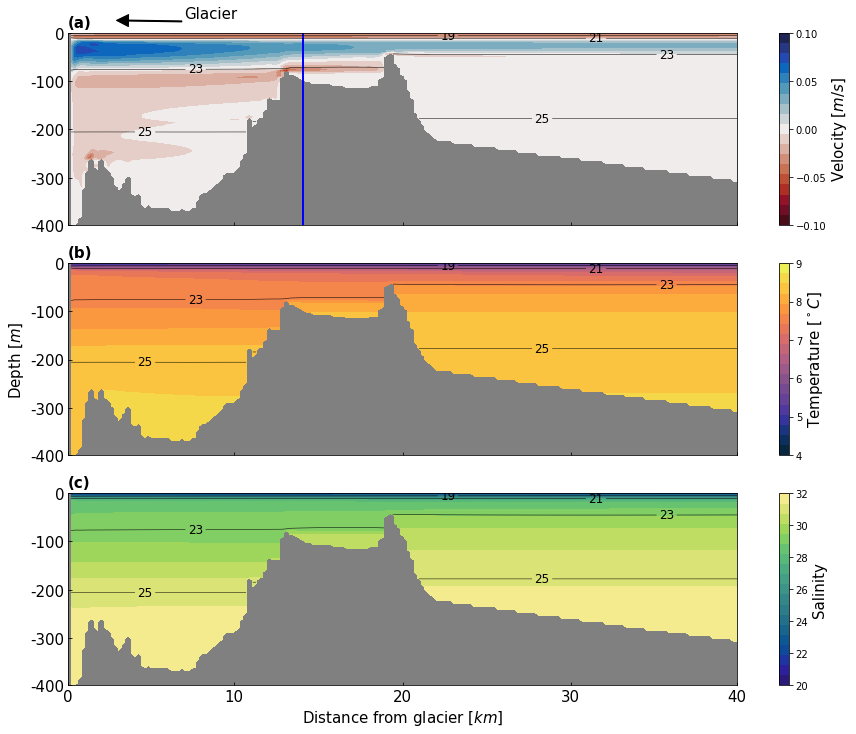

In [22]:
# Plot along-fjord velocity, temperature, and salinity
fig1, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(15,12))

t0 = 10

U, Temp, Sal, RhoA = u1.mean(0), temp1.mean(0), sal1.mean(0), den1.mean(0)-1000
pt0 = temp1[0,:,:]
mask = (pt0 == 0)
U[mask] = np.nan
Temp[mask] = np.nan
Sal[mask] = np.nan
RhoA[mask] = np.nan


cr_u = np.linspace(-0.1,0.1,20) # Contour range
cr_t = np.linspace(4,9,20)
cr_s = np.linspace(20,32,20)
cr_rho = np.linspace(1017,1027,6)-1000

# Along-fjord velocity
im1 = ax1.contourf(X, Z1, U, cr_u, cmap=cmocean.cm.balance_r) 
ax1.axvline(x=X[70], color='b',lw=2)
CS1 = ax1.contour(X,Z1,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS1, fontsize=12, inline=1)

cbar1 = fig1.colorbar(im1,ax=ax1)
cbar1.set_ticks([-0.1,-0.05,0,0.05,0.1])
cbar1.set_label('Velocity [$m/s$]', size=15)

ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=15)
#ax1.xaxis.set_visible(False)
ax1.set_xticks([X[0], 10, 20, 30, X[-1]])
ax1.set_yticks([Z1[0], -100, -200, -300, Z1[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
#ax1.set_ylabel('Depth [$m$]', size=15)
ax1.set_title(r'(a)', loc='left', size=15, weight='bold')

ax1.annotate('Glacier', xy=(3,25), xytext=(7,29), 
            xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=15, annotation_clip=False)


# Potential temperature
im2 = ax2.contourf(X, Z1, Temp, cr_t, cmap=cmocean.cm.thermal) 
#ax2.axvline(x=x_dist[120], color='g',lw=2)
CS2 = ax2.contour(X,Z1,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS2, fontsize=12, inline=1)

cbar2 = fig1.colorbar(im2,ax=ax2)
cbar2.set_ticks([4,5,6,7,8,9])
cbar2.set_label('Temperature [$^\circ C$]', size=15)

ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=15)
ax2.set_xticks([X[0], 10, 20, 30, X[-1]])
ax2.set_yticks([Z1[0], -100, -200, -300, Z1[-1]])
ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_ylabel('Depth [$m$]', size=15)
ax2.set_title(r'(b)', loc='left', size=15, weight='bold')



# Salinity
im3 = ax3.contourf(X, Z1, Sal, cr_s, cmap=cmocean.cm.haline)
#ax1.axvline(x=x_dist[120], color='g',lw=2)
CS3 = ax3.contour(X,Z1,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS3, fontsize=12, inline=1)

cbar3 = fig1.colorbar(im3,ax=ax3)
cbar3.set_ticks([20,22,24,26,28,30,32])
cbar3.set_label('Salinity', size=15)


ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=15)
ax3.set_yticks([Z1[0], -100, -200, -300, Z1[-1]])
ax3.set_yticklabels(["0","-100","-200","-300","-400"])
#ax3.set_ylabel('Depth [$m$]', size=15)
ax3.set_title(r'(c)', loc='left', size=15, weight='bold')
ax3.set_xticks([X[0], 10, 20, 30, X[-1]])
ax3.set_xticklabels(["0","10","20","30","40"])
ax3.set_xlabel('Distance from glacier [$km$]', size=15)

[Text(0.0, 0, '0'), Text(900.0, 0, '1'), Text(1800.0, 0, '2')]

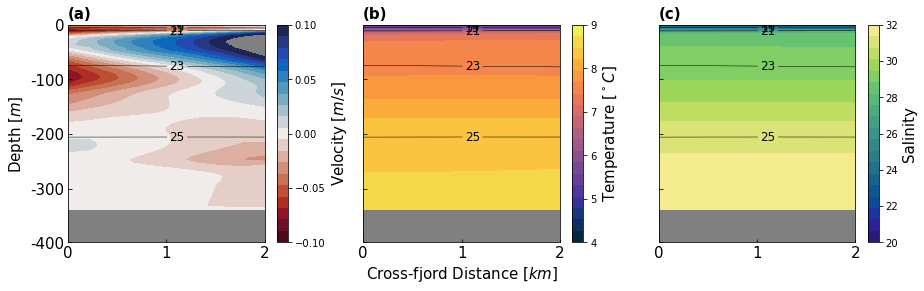

In [8]:
# Plot cross-fjord velocity, temperature, and salinity
fig2, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(15,4))

U2, Temp2, Sal2, RhoA2 = u2.mean(0), temp2.mean(0), sal2.mean(0), den2.mean(0)-1000
pt1 = temp2[0,:,:]
mask = (pt1 == 0)
U2[mask] = np.nan
Temp2[mask] = np.nan
Sal2[mask] = np.nan
RhoA2[mask] = np.nan

# import cmocean
# cr_u = np.linspace(-0.1,0.1,20) # Contour range
# cr_t = np.linspace(4,9,20)
# cr_s = np.linspace(20,32,20)
# cr_rho = np.linspace(1017,1027,6)-1000

# Along-fjord velocity
im1 = ax1.contourf(Y, Z2, U2, cr_u, cmap=cmocean.cm.balance_r) 
#ax1.axvline(x=x_dist[120], color='g',lw=2)
CS1 = ax1.contour(Y,Z2,RhoA2,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS1, fontsize=12, inline=1)

cbar1 = fig2.colorbar(im1,ax=ax1)
cbar1.set_ticks([-0.1,-0.05,0,0.05,0.1])
cbar1.set_label('Velocity [$m/s$]', size=15)

ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=15)
#ax1.xaxis.set_visible(False)
ax1.set_yticks([Z2[0], -100, -200, -300, Z2[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
ax1.set_ylabel('Depth [$m$]', size=15)
ax1.set_title(r'(a)', loc='left', size=15, weight='bold')
ax1.set_xticks([Y[0], (Y[0]+Y[-1])/2, Y[-1]])
ax1.set_xticklabels(["0","1","2"])

# Potential temperature
im2 = ax2.contourf(Y, Z2, Temp2, cr_t, cmap=cmocean.cm.thermal) 
#ax2.axvline(x=x_dist[120], color='g',lw=2)
CS2 = ax2.contour(Y,Z2,RhoA2,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS2, fontsize=12, inline=1)

cbar2 = fig2.colorbar(im2,ax=ax2)
cbar2.set_ticks([4,5,6,7,8,9])
cbar2.set_label('Temperature [$^\circ C$]', size=15)

ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=15)
#ax2.xaxis.set_visible(False)
ax2.set_yticks([Z2[0], -100, -200, -300, Z2[-1]])
#ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_title(r'(b)', loc='left', size=15, weight='bold')
ax2.set_xticks([Y[0], (Y[0]+Y[-1])/2, Y[-1]])
ax2.set_xticklabels(["0","1","2"])
ax2.set_xlabel('Cross-fjord Distance [$km$]', size=15)


# Salinity
im3 = ax3.contourf(Y, Z2, Sal2, cr_s, cmap=cmocean.cm.haline)
#ax1.axvline(x=x_dist[120], color='g',lw=2)
CS3 = ax3.contour(Y,Z2,RhoA2,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS3, fontsize=12, inline=1)

cbar3 = fig2.colorbar(im3,ax=ax3)
cbar3.set_ticks([20,22,24,26,28,30,32])
cbar3.set_label('Salinity', size=15)


ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=15)
ax3.set_yticks([Z2[0], -100, -200, -300, Z2[-1]])
#ax3.set_yticklabels(["0","-100","-200","-300","-400"])
#ax3.set_ylabel('Depth [$m$]', size=15)
ax3.set_title(r'(c)', loc='left', size=15, weight='bold')
ax3.set_xticks([Y[0], (Y[0]+Y[-1])/2, Y[-1]])
ax3.set_xticklabels(["0","1","2"])

In [12]:
t = date_range(start="2023-10-01", periods=len(T1), freq="H")
print(t)

DatetimeIndex(['2023-10-01 00:00:00', '2023-10-01 01:00:00',
               '2023-10-01 02:00:00', '2023-10-01 03:00:00',
               '2023-10-01 04:00:00', '2023-10-01 05:00:00',
               '2023-10-01 06:00:00', '2023-10-01 07:00:00',
               '2023-10-01 08:00:00', '2023-10-01 09:00:00',
               ...
               '2023-10-10 15:00:00', '2023-10-10 16:00:00',
               '2023-10-10 17:00:00', '2023-10-10 18:00:00',
               '2023-10-10 19:00:00', '2023-10-10 20:00:00',
               '2023-10-10 21:00:00', '2023-10-10 22:00:00',
               '2023-10-10 23:00:00', '2023-10-11 00:00:00'],
              dtype='datetime64[ns]', length=241, freq='H')


In [24]:
# Use UTide to check tidal velocity   
State01 = xr.open_dataset(input_file)    
State = State01.isel(T=~State01.get_index("T").duplicated())
state = State.isel(Y=range(35,45), Yp1=range(35,45))

xloc = 70 # Midfjord mooring
U = state.U.data[:,:,:,xloc].mean(2)
V = state.V.data[:,:,:,xloc].mean(2)
model_time = T1
made_time = date_range(start="2023-10-01", periods=len(T1), freq="H")
  
# In the vertical
Ut_max = np.empty(U.shape[1])
Ut_min = np.empty(U.shape[1])
for z in range(U.shape[1]):        
    coef = utide.solve(
        t, U[:,z], V[:,z],
        lat=-48.25,
        nodal=False,
        trend=False,
        method='ols',
        conf_int='linear',
        Rayleigh_min=0.95,
    )
        
    tide = utide.reconstruct(model_time, coef)
    Ut_max[z] = tide['u'].max()
    Ut_min[z] = tide['u'].min()

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ..

In [25]:
ut = np.concatenate((Ut_max, Ut_min))
print (ut, ut.max(), ut.min())

[-2.50644133e-02 -2.70597492e-02 -3.21204425e-02 -3.76459311e-02
 -3.97833776e-02 -3.13601213e-02 -1.71293471e-02 -1.63035876e-03
  8.98282600e-03  1.90050039e-02  2.62901402e-02  3.13542933e-02
  3.59486686e-02  3.78351786e-02  3.86255440e-02  3.85614540e-02
  3.78023172e-02  3.64006442e-02  3.43992462e-02  3.17781829e-02
  2.79630099e-02  2.12739048e-02  1.39995691e-02  7.22144098e-03
  1.45401358e-05 -6.29107307e-03 -1.31861050e-02 -2.19428985e-02
 -3.12695705e-02 -3.34472762e-02 -1.92321169e-02 -2.97977319e-03
  9.89286683e-04  1.37829791e-03 -2.63116152e-19  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000